Code to test that simple_pe metric does what we want

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

In [3]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

In [4]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


In [5]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
mt = conversions.mtotal_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
dist = 1.

In [6]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff,
          'distance':dist,
        }

In [7]:
dx = {'chirp_mass':0.5, 
          'symmetric_mass_ratio':0.02,
          'chi_eff':0.02
         }

Make original and varied waveform

In [8]:
h = metric.make_waveform(params, psds['delta_f'], psds['f_low'], len(pycbc_psd['harm']))
h_prime = metric.make_offset_waveform(params, dx, 1, psds['delta_f'], psds['f_low'], len(pycbc_psd['harm']))

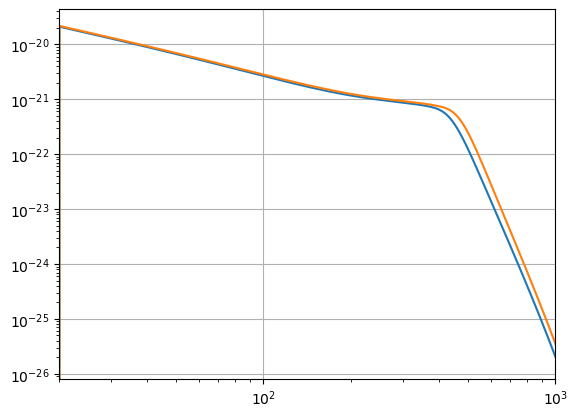

In [9]:
plt.loglog(h.sample_frequencies, abs(h))
plt.loglog(h_prime.sample_frequencies, abs(h_prime))
plt.xlim(20,1000)
plt.grid()

Check that the parameters are physical

In [10]:
scales = np.linspace(-10,10,21)
alphas = np.zeros_like(scales)
for i,s in enumerate(scales):
    alphas[i] = metric.check_physical(params, dx, scaling=s)

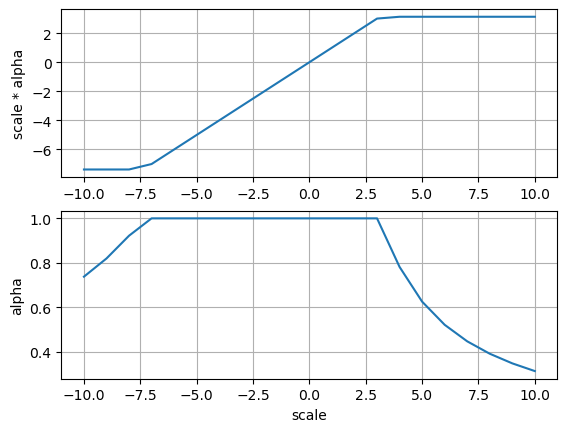

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(scales, scales*alphas)
ax1.set(ylabel='scale * alpha')
ax1.grid()

ax2.plot(scales, alphas)
ax2.set(xlabel='scale', ylabel='alpha')
ax2.grid()

In [12]:
for k,i in dx.items():
    print('%s at lower limit: %.2f' % (k, params[k] + i * (alphas[0] * scales[0])))
    print('%s at upper limit: %.2f' % (k, params[k] + i * (alphas[-1] * scales[-1])))

chirp_mass at lower limit: 10.96
chirp_mass at upper limit: 16.21
symmetric_mass_ratio at lower limit: 0.04
symmetric_mass_ratio at upper limit: 0.25
chi_eff at lower limit: 0.08
chi_eff at upper limit: 0.29


Check average mismatch

In [13]:
dist=1.
scaling=1.

In [14]:
metric.average_mismatch(params, dx, scaling, psds['f_low'], pycbc_psd['harm'], verbose=True)

Had to scale steps to 1.00, 1.00
Mismatches 0.111, 0.119


0.11543725206730437

Check scaling of vector to desired mismatch

In [15]:
desired_mismatch = 0.03
scale = metric.scale_dx(params, dx, desired_mismatch, psds['f_low'], pycbc_psd['harm'])

Check this is right

In [16]:
ave_mis = metric.average_mismatch(params, dx, scale, psds['f_low'], pycbc_psd['harm'], verbose=True)
print("desired mismatch = %.3g, average mismatch returned = %.3g" % (desired_mismatch, ave_mis))

Had to scale steps to 1.00, 1.00
Mismatches 0.0298, 0.0304
desired mismatch = 0.03, average mismatch returned = 0.0301


Calculate the metric

In [17]:
g = metric.Metric(params, dx.keys(), desired_mismatch, psds['f_low'], pycbc_psd['harm'], 
                  approximant="IMRPhenomD", tolerance=1e-2)

Print the directions used to calculate the metric and the coordinate metric along these directions

In [18]:
print(g.dxs)
print(g.coordinate_metric)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       0.084203       0.000000       0.000000       
1       0.000000       0.007318       0.000000       
2       0.000000       0.000000       0.023374       

[[ 0.02995476 -0.02800053 -0.02820465]
 [-0.02800053  0.02987847  0.02920767]
 [-0.02820465  0.02920767  0.03004795]]


Now, update the metric.  We should have new directions and a better (more close to diagonal) metric

In [19]:
g.calc_metric_error()
print("metric error = %.2g" %g.err)

metric error = 0.029


In [20]:
g.update_metric()

In [21]:
print(g.dxs)
print(g.coordinate_metric)
g.calc_metric_error()
print("metric error = %.2g" %g.err)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       0.000544       -0.006651      -0.002045      
1       -0.346890      -0.008828      -0.063490      
2       -0.052658      -0.096914      0.301183       

[[ 0.03002644 -0.001474   -0.00518798]
 [-0.001474    0.02992953  0.01329947]
 [-0.00518798  0.01329947  0.02989492]]
metric error = 0.013


In [22]:
g.iteratively_update_metric()

In [23]:
print(g.dxs)
print(g.coordinate_metric)
g.calc_metric_error()
print("metric error = %.2g" %g.err)

idx     chirp_mass     symmetric_mass_ratiochi_eff        
0       -0.000521      0.006641       0.002084       
1       0.210278       0.058881       -0.135005      
2       0.192429       -0.069453      0.269428       

[[ 3.00348234e-02  6.82013954e-05 -4.51147316e-05]
 [ 6.82013954e-05  3.00108809e-02 -2.43352073e-05]
 [-4.51147316e-05 -2.43352073e-05  2.99494223e-02]]
metric error = 6.8e-05


In [24]:
projected_directions = ['symmetric_mass_ratio', 'chi_eff']

In [25]:
g.project_metric(projected_directions)

In [26]:
print(g.metric)

[[  3.82655375 -43.7379831  -13.81930631]
 [-43.7379831  558.08112731 175.00957733]
 [-13.81930631 175.00957733  55.23847401]]


In [27]:
print(g.projected_directions)
print(g.projected_metric)

['symmetric_mass_ratio', 'chi_eff']
[[58.1505663  17.05319557]
 [17.05319557  5.3311059 ]]


In [28]:
kept = np.ones(g.ndim, dtype=bool)
for i,x in enumerate(g.dx_directions):
            if x not in projected_directions:
                kept[i] = False

In [29]:
kept

array([False,  True,  True])

In [30]:
ginv = np.linalg.inv(g.metric)
projected_metric = np.linalg.inv(ginv[kept][:,kept])

In [31]:
print(projected_metric)

[[58.1505663  17.05319557]
 [17.05319557  5.3311059 ]]
